# Import

In [63]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import nilearn as nil
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm
from scipy import ndimage
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.metrics import confusion_matrix, silhouette_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, log_loss
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
from numpy.random import seed
import SimpleITK as sitk
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
import math
import random
import matplotlib.patheffects as PathEffects
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten, Lambda, Dropout
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [65]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [66]:
ALPHA = 0.3
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, CHANNELS = (96, 96, 96, 1)
BUFFER_SIZE = 1000
BATCH_SIZE = 10
current_group = 'gender'
current_mode = 'mmd'

if current_group == 'age':
    group_class = 3

# Load Data

In [67]:
fold = "1"
data = pd.read_csv('.\\data\\combined_data.csv')
data_train = pd.read_csv('.\\data/train_p0_fold_' + fold + '.csv')
data_val = pd.read_csv('.\\data\\val_p0_fold_' + fold + '.csv')
data_test = pd.read_csv('.\\data\\test_p0_fold_' + fold + '.csv')

In [68]:
data_train = data_train[data_train.Group != 'MCI']
data_val = data_val[data_val.Group != 'MCI']
data_test = data_test[data_test.Group != 'MCI']

In [69]:
data_val.head()

,Links,Group,Sex,Age,ETH,RACE
0,D:\Lab\ADNI\094_S_1397\MPR__GradWarp__B1_Corre...,AD,F,55,Not Hisp/Latino,White
1,D:\Lab\ADNI\094_S_1397\MPR__GradWarp__B1_Corre...,AD,F,56,Not Hisp/Latino,White
2,D:\Lab\ADNI\094_S_1397\MPR__GradWarp__B1_Corre...,AD,F,56,Not Hisp/Latino,White
3,D:\Lab\ADNI\094_S_1397\MPR__GradWarp__B1_Corre...,AD,F,56,Not Hisp/Latino,White
4,D:\Lab\ADNI\020_S_0213\MPR__GradWarp__B1_Corre...,AD,M,63,Not Hisp/Latino,Black


In [70]:
seed(1)

In [71]:
def get_id(l):
    return l.split('\\')[3]

get_id(data_train['Links'][0])

'033_S_0733'

In [72]:
sid_ad = set()
sid_cn = set()
for path in tqdm(data_train.to_numpy()):
    # print(idx)
    if path[1] == 'AD':
        sid_ad.add(get_id(path[0]))
    else:
        sid_cn.add(get_id(path[0]))

100%|█████████████████████████████████████████████████████████████████████████| 1041/1041 [00:00<00:00, 1040827.29it/s]


In [73]:
len(sid_ad), len(sid_cn)

(115, 140)

In [74]:
count = 0
for each in sid_ad:
    if each in sid_cn:
        count += 1
count

0

# Preprocess

In [75]:
def bbox(mask):
    r = np.any(mask, axis=(1, 2))
    c = np.any(mask, axis=(0, 2))
    z = np.any(mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax, zmin, zmax

In [76]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.

    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad

    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer[0],slicer[1],slicer[2]], to_padding, **kwargs)

In [96]:
def apply_mask_train(filename, labels, groups):
    # name = tf.strings.split(filename, sep= '\\')
    # masked_filename = name[:-1]
    # image_name = name[-1]
    # masked_filename = '\\'.join(masked_filename) + '\\Masked.nii'
    # masked_filename = tf.strings.join(masked_filename, separator='\\') +'\\c1' + image_name
    # print(masked_filename)
    img = nib.load(filename.numpy().decode()).get_fdata()
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    groups = tf.convert_to_tensor(groups, dtype=tf.int32)
    return img, labels, groups

def wrapper_train(filename, labels, groups):
    img, label, group = tf.py_function(apply_mask_train, [filename, labels, groups], [tf.float32, tf.int32, tf.int32])
    return img, label, group

In [78]:
def _fixup_shape(images, labels, groups):
    images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    labels.set_shape([1])
    groups.set_shape([1])
    return images, labels, groups

# Dataset

In [97]:
img_path_train, img_path_val, img_path_test = data_train['Links'].to_numpy(), data_val['Links'].to_numpy(), data_test['Links'].to_numpy()
label_train, label_val, label_test = data_train['Group'].to_numpy(), data_val['Group'].to_numpy(), data_test['Group'].to_numpy()
sex_train, sex_val, sex_test = data_train['Sex'].to_numpy(), data_val['Sex'].to_numpy(), data_test['Sex'].to_numpy()
age_train, age_val, age_test = data_train['Age'].to_numpy(), data_val['Age'].to_numpy(), data_test['Age'].to_numpy()
label_to_index = dict((name, index) for index, name in enumerate(np.unique(label_train)))
index_to_label = dict((index, name) for index, name in enumerate(np.unique(label_train)))

sex_to_index = dict((name, index) for index, name in enumerate(np.unique(sex_train)))
index_to_sex = dict((index, name) for index, name in enumerate(np.unique(sex_train)))

In [98]:
label_to_index, index_to_label

({'AD': 0, 'CN': 1}, {0: 'AD', 1: 'CN'})

In [99]:
for idx, each in enumerate(age_train):
    if each <= 70:
        age_train[idx] = 0
    elif each <= 80:
        age_train[idx] = 1
    else:
        age_train[idx] = 2
    
for idx, each in enumerate(age_val):
    if each <= 70:
        age_val[idx] = 0
    elif each <= 80:
        age_val[idx] = 1
    else:
        age_val[idx] = 2

for idx, each in enumerate(age_test):
    if each <= 70:
        age_test[idx] = 0
    elif each <= 80:
        age_test[idx] = 1
    else:
        age_test[idx] = 2

In [100]:
age_train = np.array(age_train).reshape((-1, 1))
age_val = np.array(age_val).reshape((-1, 1))
age_test = np.array(age_test).reshape((-1, 1))

In [101]:
label_train = [label_to_index[l] for l in label_train]
label_train = np.array(label_train).reshape((-1, 1))
label_val = [label_to_index[l] for l in label_val]
label_val = np.array(label_val).reshape((-1, 1))
label_test = [label_to_index[l] for l in label_test]
label_test = np.array(label_test).reshape((-1, 1))

In [102]:
sex_train = [sex_to_index[l] for l in sex_train]
sex_train = np.array(sex_train).reshape((-1, 1))
sex_val = [sex_to_index[l] for l in sex_val]
sex_val = np.array(sex_val).reshape((-1, 1))
sex_test = [sex_to_index[l] for l in sex_test]
sex_test = np.array(sex_test).reshape((-1, 1))

In [103]:
if current_group == 'age':
    target_group_train, target_group_val, target_group_test = age_train, age_val, age_test
else:
    target_group_train, target_group_val, target_group_test = sex_train, sex_val, sex_test
    
dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), label_train, target_group_train))
dataset_train = dataset_train.map(wrapper_train, 
                      num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), label_val, target_group_val))
dataset_val = dataset_val.map(wrapper_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), label_test, target_group_test))
dataset_test = dataset_test.map(wrapper_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

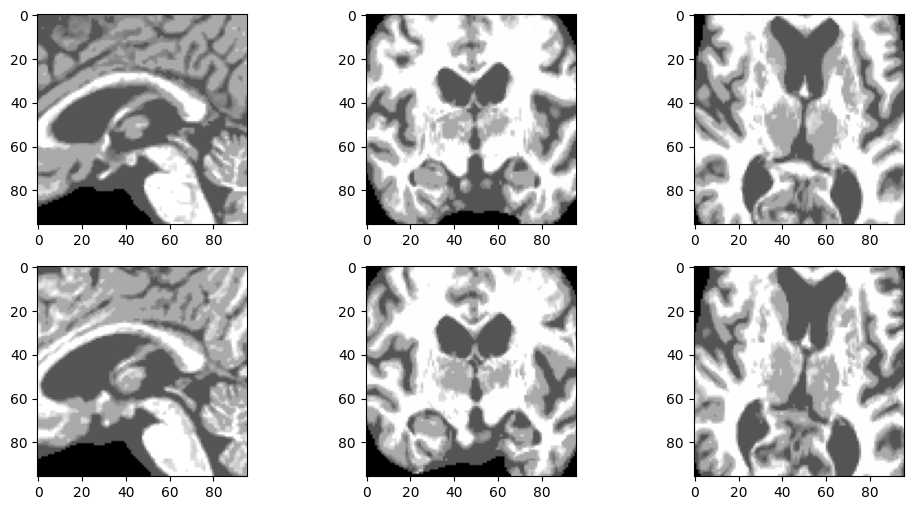

In [104]:
for img, label, group in dataset_val.take(1):
    fig, ax = plt.subplots(2,3, figsize = (12, 6))
    ax[0][0].imshow(img[0][:,:,img[0].shape[2]//2], cmap='gray')
    ax[0][1].imshow(img[0][:,img[0].shape[1]//2, :], cmap='gray')
    ax[0][2].imshow(img[0][img[0].shape[0]//2], cmap='gray')
    ax[1][0].imshow(img[3][:,:,img[1].shape[2]//2], cmap='gray')
    ax[1][1].imshow(img[3][:,img[1].shape[1]//2, :], cmap='gray')
    ax[1][2].imshow(img[3][img[1].shape[0]//2], cmap='gray')

# Classifier

In [105]:
# from github: https://github.com/JihongJu/keras-resnet3d/blob/master/resnet3d/resnet3d.py
def _bn_relu(input):
    """
    Helper to build a BN -> relu block (by @raghakot).
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters, 
            kernel_size=kernel_size,
            strides=strides, 
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer
            )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """
    Helper to build a  BN -> relu -> conv3d block.
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
                   filters=filters, 
                   kernel_size=kernel_size,
                   strides=strides, 
                   kernel_initializer=kernel_initializer,
                   padding=padding,
                   kernel_regularizer=kernel_regularizer
                   )(activation)
    return f


def _shortcut3d(input, residual):
    """
    3D shortcut to match input and residual and merges them with "sum".
    """
    stride_dim1 = ceil(input.shape[DIM1_AXIS] \
        / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] \
        / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] \
        / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", 
            padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters, 
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0)
                )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters, 
                kernel_size=(3, 3, 3),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        residual = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        conv_3_3 = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4, 
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer
            )(conv_3_3)
        return _shortcut3d(input, residual)
    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

In [106]:
class Resnet3DBuilder(object):
    """
    ResNet3D.
    """

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """
        Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                     "Input shape should be a tuple "
                     "(conv_dim1, conv_dim2, conv_dim3, channels) "
                     "for tensorflow as backend or "
                     "(channels, conv_dim1, conv_dim2, conv_dim3) "
                     "for theano as backend"
                     )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64, 
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor)
            )(input)
        pool1 = MaxPooling3D(
            pool_size=(3, 3, 3), 
            strides=(2, 2, 2),
            padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn, 
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r, 
                is_first_layer=(i == 0)
                )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(block.shape[DIM1_AXIS],
                       block.shape[DIM2_AXIS],
                       block.shape[DIM3_AXIS]),
            strides=(1, 1, 1)
            )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """
        Build resnet 18.
        """
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [107]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS)
builder = Resnet3DBuilder()
model = builder.build_resnet_18(input_shape, 2)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 96,  0                                            
__________________________________________________________________________________________________
conv3d_60 (Conv3D)              (None, 48, 48, 48, 6 22016       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 48, 48, 48, 6 256         conv3d_60[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 48, 48, 48, 6 0           batch_normalization_51[0][0]     
____________________________________________________________________________________________

# Train

In [108]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
# l_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)


train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

train_loss = tf.keras.metrics.Mean(name='train_lp_loss')
val_loss = tf.keras.metrics.Mean(name='val_lp_loss')

In [109]:
# from github: https://github.com/MLforHealth/CXR_Fairness/blob/master/cxr_fairness/algorithms.py
def my_cdist(x1, x2):
    x1_norm = tf.reduce_sum(tf.math.pow(x1, 2), axis=-1, keepdims=True)
    x2_norm = tf.reduce_sum(tf.math.pow(x2, 2), axis=-1, keepdims=True)
    
    mm = -2*tf.linalg.matmul(x1, tf.transpose(x2, perm=[1, 0]))

    madd = tf.math.add(tf.transpose(x2_norm, perm=[1, 0]), mm)

    res = tf.math.add(madd, x1_norm)

    return tf.clip_by_value(res, clip_value_min=1e-30, clip_value_max=1e30)

def gaussian_kernel(x, y, gamma=[0.001, 0.01, 0.1, 1, 10, 100,
                                       1000]):
    D = my_cdist(x, y)
    
    K = tf.zeros_like(D)

    for g in gamma:
        K = tf.math.add(K, tf.math.exp(tf.math.multiply(D, -g)))

    return K/len(gamma)

def mmd(x, y):
    # https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution
    Kxx = tf.reduce_mean(gaussian_kernel(x, x))
    Kyy = tf.reduce_mean(gaussian_kernel(y, y))
    Kxy = tf.reduce_mean(gaussian_kernel(x, y))
    return Kxx + Kyy - 2 * Kxy

In [110]:
for images, label, groups in dataset_val.take(1):
    pred = model(images)
    loss = loss_object(label, pred) 

In [111]:
if current_group == 'age':
    group = [0,1,2]
else:
    group = [0,1]
    
@tf.function
def train_step(images, labels, groups, mode='mean'):
    penalty = 0.0
    with tf.GradientTape() as tape:
        pred = model(images)
        loss = loss_object(labels, pred)  
        for target in group:
            mask = groups == target
            grp_trg = pred[tf.squeeze(mask)][:,-1]
            all_trg = pred[:,-1]
            if len(grp_trg) > 0:
                if mode == 'mmd':
                    penalty +=  mmd(tf.expand_dims(grp_trg, -1), tf.expand_dims(all_trg,-1))
                else:
                    penalty += tf.math.abs(tf.reduce_mean(grp_trg) -  tf.reduce_mean(pred))
        if mode == 'mean':
            total_loss = loss + 1*penalty
        else:
            total_loss = loss + 1*penalty
        
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    train_loss(total_loss)
    train_accuracy(labels, pred)
    

In [112]:
@tf.function
def val_step(images, labels, domains):
    pred = model(images)
    loss = loss_object(labels, pred)  
    val_loss(loss)
    val_accuracy(labels, pred)
    
        

In [113]:
def val(domain=True):
    for batch in tqdm(dataset_val):
        val_step(*batch)
        
def test(domain=True):
    for batch in tqdm(dataset_test):
        val_step(*batch)

def reset_metrics(target):

    if target == 'train':
        train_loss.reset_states()
        train_accuracy.reset_states()

    if target == 'val':
        val_loss.reset_states()
        val_accuracy.reset_states()


In [ ]:
epochs = 30
prev = 0
for epoch in range(epochs):
    for batch in tqdm(dataset_train):
        train_step(*batch, mode = current_mode)

    print("Training: Epoch {} :\t Accuracy : {:.3%}, loss : {}"
          .format(epoch, train_accuracy.result(), train_loss.result()))
    
    reset_metrics('train')
    
    val()
    val_acc = val_accuracy.result()
    print("Val: Accuracy : {:.3%}, loss : {}"
          .format(val_accuracy.result(), val_loss.result()))
    
    if val_acc > prev:
        prev = val_acc
        print('save acc: {}'.format(val_acc))
        model.save_weights("./model/" + current_mode + "/distmatch_" + current_group)
        
    reset_metrics('val')

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:35<00:00,  1.09it/s]


Training: Epoch 0 :	 Accuracy : 58.173%, loss : 413.8250427246094


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.98it/s]


Val: Accuracy : 39.167%, loss : 0.9754269123077393
save acc: 0.3916666805744171


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 1 :	 Accuracy : 67.019%, loss : 0.6848640441894531


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.33it/s]


Val: Accuracy : 60.417%, loss : 0.8295881748199463
save acc: 0.6041666865348816


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:29<00:00,  1.17it/s]


Training: Epoch 2 :	 Accuracy : 73.846%, loss : 0.5965968370437622


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.29it/s]


Val: Accuracy : 68.750%, loss : 0.6079336404800415
save acc: 0.6875


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:30<00:00,  1.14it/s]


Training: Epoch 3 :	 Accuracy : 76.058%, loss : 0.5641739368438721


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.02it/s]


Val: Accuracy : 70.417%, loss : 0.569084882736206
save acc: 0.7041666507720947


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 4 :	 Accuracy : 81.058%, loss : 0.4735860824584961


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.03it/s]


Val: Accuracy : 68.750%, loss : 0.6690600514411926


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 5 :	 Accuracy : 85.096%, loss : 0.472631573677063


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.00it/s]


Val: Accuracy : 68.333%, loss : 0.6440604329109192


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 6 :	 Accuracy : 85.769%, loss : 0.4494217336177826


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


Val: Accuracy : 67.083%, loss : 0.7044596076011658


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 7 :	 Accuracy : 87.885%, loss : 0.42003872990608215


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.24it/s]


Val: Accuracy : 71.250%, loss : 0.570638120174408
save acc: 0.7124999761581421


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:35<00:00,  1.09it/s]


Training: Epoch 8 :	 Accuracy : 88.462%, loss : 0.38543906807899475


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.35it/s]


Val: Accuracy : 68.750%, loss : 0.5929383039474487


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 9 :	 Accuracy : 88.846%, loss : 0.3874979019165039


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


Val: Accuracy : 71.667%, loss : 0.5614094138145447
save acc: 0.7166666388511658


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 10 :	 Accuracy : 90.865%, loss : 0.34519195556640625


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.99it/s]


Val: Accuracy : 70.833%, loss : 0.6761320233345032


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:30<00:00,  1.14it/s]


Training: Epoch 11 :	 Accuracy : 92.981%, loss : 0.32762807607650757


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.99it/s]


Val: Accuracy : 72.500%, loss : 0.6235603094100952
save acc: 0.7250000238418579


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:33<00:00,  1.11it/s]


Training: Epoch 12 :	 Accuracy : 94.615%, loss : 0.28854840993881226


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


Val: Accuracy : 73.333%, loss : 0.5535591244697571
save acc: 0.7333333492279053


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:30<00:00,  1.14it/s]


Training: Epoch 13 :	 Accuracy : 94.327%, loss : 0.2949943244457245


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.33it/s]


Val: Accuracy : 72.083%, loss : 0.6222385168075562


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:33<00:00,  1.11it/s]


Training: Epoch 14 :	 Accuracy : 95.096%, loss : 0.26665404438972473


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.01it/s]


Val: Accuracy : 74.167%, loss : 0.5533102750778198
save acc: 0.7416666746139526


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [01:31<00:00,  1.14it/s]


Training: Epoch 15 :	 Accuracy : 95.962%, loss : 0.2436055988073349


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.04it/s]


Val: Accuracy : 76.250%, loss : 0.5221887230873108
save acc: 0.762499988079071


 86%|█████████████████████████████████████████████████████████████████████▎           | 89/104 [01:22<00:05,  2.78it/s]